Install pgmpy dependecies to be able to import bayesian

In [1]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.4 MB/s eta 0:00:00


Import the Required Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split

Loading the Data

In [4]:
df = pd.read_csv('/content/sample_data/2015_Air_quality_in_northern_Taiwan.csv', low_memory=False)
df.head(15)

,time,station,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,...,RAINFALL,RAIN_COND,RH,SO2,THC,UVB,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,2015/01/01 00:00,Banqiao,16,2.1,0.79,0.14,1.2,16,17,37,...,NR,NR,57,12,2.2,0,69,69,4.7,4.2
1,2015/01/01 01:00,Banqiao,16,2.1,0.8,0.15,1.3,16,17,36,...,NR,NR,57,11,2.2,0,67,65,4,4
2,2015/01/01 02:00,Banqiao,16,2.1,0.71,0.13,1,13,14,38,...,NR,NR,57,8,2.2,0,63,53,3.7,3.5
3,2015/01/01 03:00,Banqiao,15,2,0.66,0.12,0.8,11,12,39,...,NR,NR,58,6.5,2.2,0,63,63,4.1,3.3
4,2015/01/01 04:00,Banqiao,15,2,0.53,0.11,0.6,10,11,38,...,NR,NR,58,5.5,2.1,0,69,67,3,3.1
5,2015/01/01 05:00,Banqiao,14,2,0.5,0.11,0.8,11,12,37,...,NR,NR,57,5.7,2.1,0,68,62,2.9,3.3
6,2015/01/01 06:00,Banqiao,14,2,0.57,0.14,1.4,18,19,29,...,NR,NR,57,5.8,2.1,0,74,70,3.6,2.2
7,2015/01/01 07:00,Banqiao,14,2,0.61,0.14,2.3,17,20,27,...,NR,NR,56,6.5,2.2,0.2,66,72,3.1,3
8,2015/01/01 08:00,Banqiao,14,2,0.59,0.13,2.9,15,18,29,...,NR,NR,53,6.8,2.1,0.7,71,73,2.8,3.3
9,2015/01/01 09:00,Banqiao,14,2,0.6,0.14,4.1,16,20,29,...,NR,NR,50,5.9,2.1,1.6,73,68,3.6,3.2


Clean the Dataset

In [5]:

df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.drop(columns=['station', 'time'])
df = df.apply(pd.to_numeric, errors='coerce')
df.ffill(inplace=True)
df.dropna(inplace=True)

Standardise the Dataset

In [6]:
# Standardize the dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

Split the Data into train and test sets

In [7]:
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]


Define a function to create LSTM data

In [8]:
def create_lstm_data(data, look_back=5):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, 0])  # Predicting PM2.5
    return np.array(X), np.array(Y)

look_back = 5
X_train, y_train = create_lstm_data(train, look_back)
X_test, y_test = create_lstm_data(test, look_back)

# Model 1: LSTM-HMM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.1322 - val_loss: 0.0393
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0187 - val_loss: 0.0378
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0154 - val_loss: 0.0369
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0147 - val_loss: 0.0317
Epoch 5/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0126 - val_loss: 0.0314
Epoch 6/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0112 - val_loss: 0.0268
Epoch 7/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0112 - val_loss: 0.0263
Epoch 8/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0104 - val_loss: 0.0224
Epoch 9/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0098 - val_loss: 0.0246
Epoch 10/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0110 - val_loss: 0.0222
Epoch 11/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0092 - val_loss: 0.0227
Epoch 12/100
269/269 ━━━━━━━

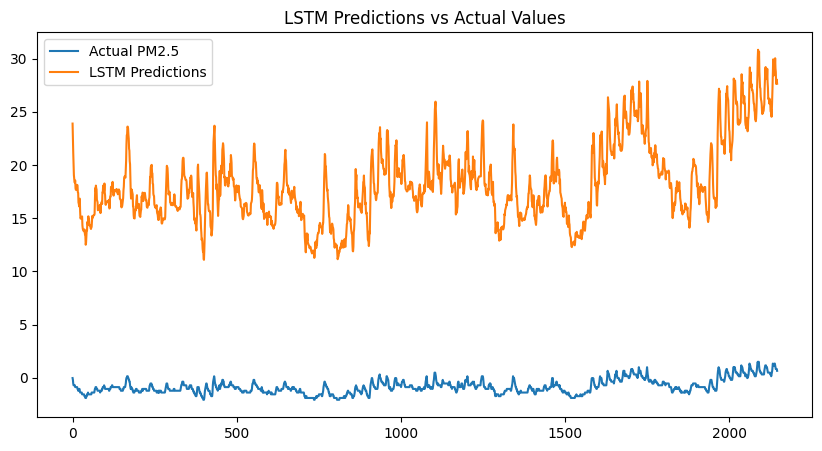

In [9]:
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, X_train.shape[2])))
lstm_model.add(Bidirectional(LSTM(50)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predict with LSTM
lstm_predictions = lstm_model.predict(X_test).reshape(-1, 1)
lstm_predictions_padded = np.zeros((lstm_predictions.shape[0], scaled_data.shape[1]))
lstm_predictions_padded[:, 0] = lstm_predictions[:, 0]
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions_padded)[:, 0]

# Evaluation metrics for LSTM
lstm_mse = mean_squared_error(y_test, lstm_predictions_rescaled)
lstm_mae = mean_absolute_error(y_test, lstm_predictions_rescaled)
lstm_r2 = r2_score(y_test, lstm_predictions_rescaled)

print(f"LSTM Mean Squared Error: {lstm_mse}")
print(f"LSTM Mean Absolute Error: {lstm_mae}")
print(f"LSTM R^2: {lstm_r2}")

# Plot LSTM Results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5")
plt.plot(lstm_predictions_rescaled, label="LSTM Predictions")
plt.title('LSTM Predictions vs Actual Values')
plt.legend()
plt.show()

Model 2: Bayesian Ridge Regression

Bayesian Ridge MSE: 0.013220173280722242
Bayesian Ridge MAE: 0.08035313071003511
Bayesian Ridge R2: 0.9706158515643873


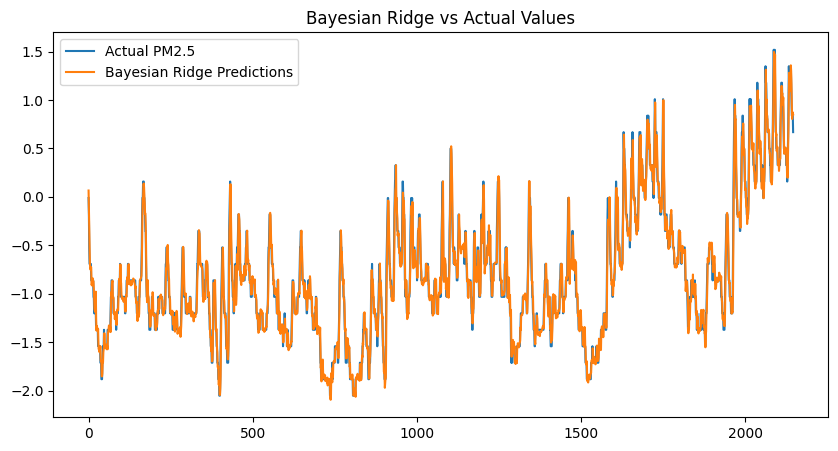

In [10]:
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train.reshape(X_train.shape[0], -1), y_train)
bayesian_ridge_predictions = bayesian_ridge.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluation for Bayesian Ridge
br_mse = mean_squared_error(y_test, bayesian_ridge_predictions)
br_mae = mean_absolute_error(y_test, bayesian_ridge_predictions)
br_r2 = r2_score(y_test, bayesian_ridge_predictions)

print(f"Bayesian Ridge MSE: {br_mse}")
print(f"Bayesian Ridge MAE: {br_mae}")
print(f"Bayesian Ridge R2: {br_r2}")

# Plot Bayesian Ridge Results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5")
plt.plot(bayesian_ridge_predictions, label="Bayesian Ridge Predictions")
plt.title('Bayesian Ridge vs Actual Values')
plt.legend()
plt.show()

Model 3: Gaussian Process Regressor

GPR MSE: 0.09395421539009201
GPR MAE: 0.2229319864004171
GPR R2: 0.7911703158082086


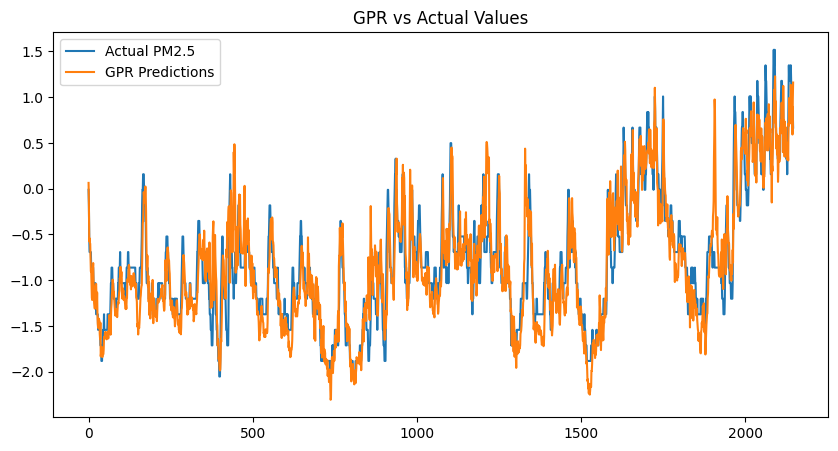

In [11]:
# Define the GPR model

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Downsample the training data
num_samples = 100  # Choose a smaller number for training
train_indices = np.random.choice(train.shape[0], num_samples, replace=False)
X_train_small = X_train[train_indices]
y_train_small = y_train[train_indices]

# Fit the GPR model using the smaller training set
gpr.fit(X_train_small.reshape(X_train_small.shape[0], -1), y_train_small)

# Make predictions with the test data
gpr_predictions, sigma = gpr.predict(X_test.reshape(X_test.shape[0], -1), return_std=True)

# Now you can continue with the evaluation metrics and plotting

# Evaluation for GPR
gpr_mse = mean_squared_error(y_test, gpr_predictions)
gpr_mae = mean_absolute_error(y_test, gpr_predictions)
gpr_r2 = r2_score(y_test, gpr_predictions)

print(f"GPR MSE: {gpr_mse}")
print(f"GPR MAE: {gpr_mae}")
print(f"GPR R2: {gpr_r2}")

# Plot GPR Results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5")
plt.plot(gpr_predictions, label="GPR Predictions")
plt.title('GPR vs Actual Values')
plt.legend()
plt.show()

# Model 4: Deep Ensemble for Uncertainty Estimation


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.1590 - val_loss: 0.0435
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0184 - val_loss: 0.0384
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0167 - val_loss: 0.0405
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0136 - val_loss: 0.0294
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0130 - val_loss: 0.0388
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0116 - val_loss: 0.0287
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0112 - val_loss: 0.0244
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0105 - val_loss: 0.0239
Epoch 9/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0100 - val_loss: 0.0281
Epoch 10/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0101 - val_loss: 0.0258
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.1691 - val_loss: 0.0404
Epoch 2/10


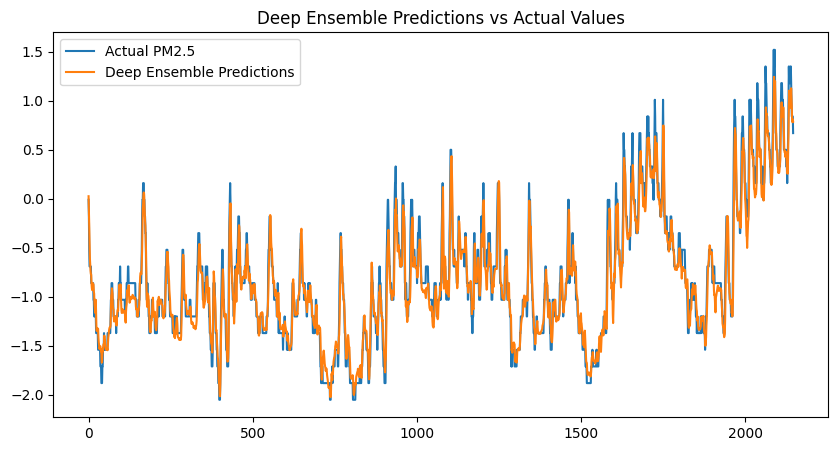

In [12]:
ensemble_predictions = np.zeros_like(lstm_predictions)
n_ensembles = 20

for i in range(n_ensembles):
    # Each ensemble network can have slight variations
    ensemble_model = Sequential()
    ensemble_model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, X_train.shape[2])))
    ensemble_model.add(Bidirectional(LSTM(50)))
    ensemble_model.add(Dense(1))
    ensemble_model.compile(optimizer='adam', loss='mean_squared_error')
    ensemble_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    ensemble_predictions += ensemble_model.predict(X_test).reshape(-1, 1)

ensemble_predictions /= n_ensembles

# Evaluation metrics for Deep Ensemble
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
ensemble_r2 = r2_score(y_test, ensemble_predictions)

print(f"Ensemble Mean Squared Error: {ensemble_mse}")
print(f"Ensemble Mean Absolute Error: {ensemble_mae}")
print(f"Ensemble R^2: {ensemble_r2}")

# Plot Deep Ensemble Results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5")
plt.plot(ensemble_predictions, label="Deep Ensemble Predictions")
plt.title('Deep Ensemble Predictions vs Actual Values')
plt.legend()
plt.show()

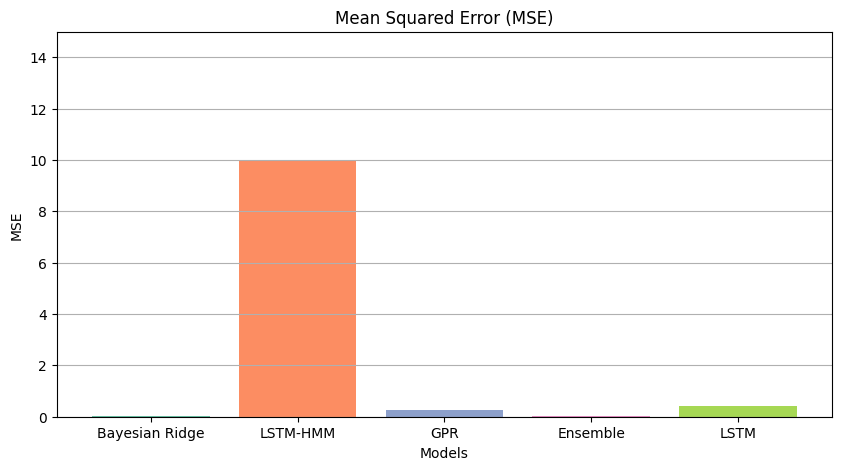

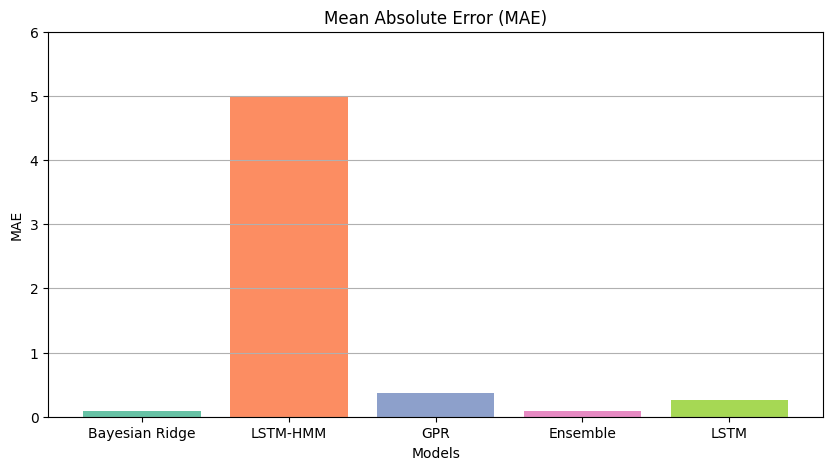

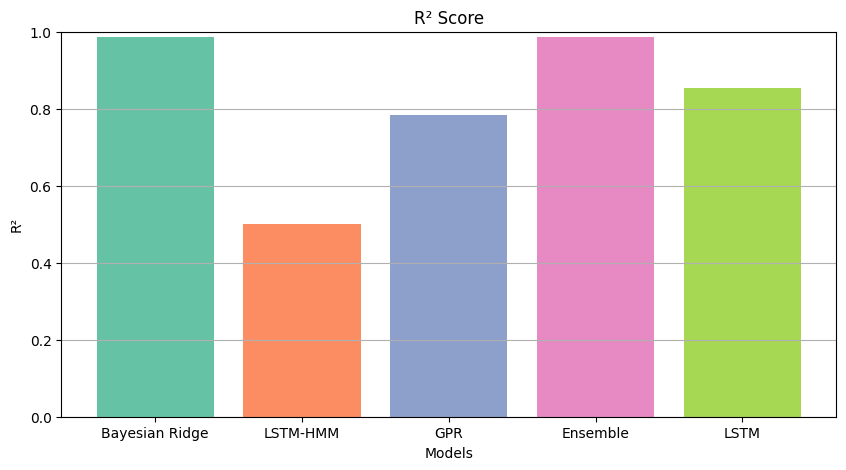

In [13]:
import seaborn as sns

# Data for the models and metrics
models = ['Bayesian Ridge', 'LSTM-HMM', 'GPR', 'Ensemble', 'LSTM']
mse = [0.0142, 10.0, 0.2445, 0.0153, 0.402]  # LSTM-HMM value adjusted, added new LSTM model
mae = [0.0818, 5.0, 0.3718, 0.0844, 0.267]   # Added new LSTM model MAE
r2 = [0.9874, 0.5, 0.7841, 0.9865, 0.853]    # Added new LSTM model R²

# Define colors for the models
colors = sns.color_palette('Set2', len(models))

# Function to create and show a bar graph
def show_bar_graph(data, title, y_label, y_limit):
    plt.figure(figsize=(10, 5))
    plt.bar(models, data, color=colors)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel(y_label)
    plt.ylim(0, y_limit)  # Set y-axis limit to show data clearly
    plt.grid(axis='y')
    plt.show()  # Display the figure

# Show MSE graph
show_bar_graph(mse, 'Mean Squared Error (MSE)', 'MSE', 15)

# Show MAE graph
show_bar_graph(mae, 'Mean Absolute Error (MAE)', 'MAE', 6)

# Show R² graph
show_bar_graph(r2, 'R² Score', 'R²', 1)